In [63]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import pickle as pkl
import time
from random import shuffle
import pandas as pd 
import spectral
import matplotlib.pyplot as plt
import pylab as pl
import scipy
import IndianPinesCNN
#import seaborn as sns
from collections import Counter
import Spatial_dataset as input_data
import patch_size
import os
#print IndianPinesCNN.IMAGE_PIXELS

In [64]:
import scipy.io as io
DATA_PATH = os.path.join(os.getcwd(),"Data")
input_image = scipy.io.loadmat(os.path.join(DATA_PATH, "Indian_pines.mat"))['indian_pines']
output_image = scipy.io.loadmat(os.path.join(DATA_PATH, "Indian_pines_gt.mat"))['indian_pines_gt']

#model_name = 'model-spatial-11X11.ckpt-3999'
model_name = os.getcwd()+'/Data/model-spatial-CNN.ckpt'
# input_image = np.rot90(input_image)
# output_image = np.rot90(output_image)
height = output_image.shape[0]
width = output_image.shape[1]
PATCH_SIZE = patch_size.patch_size
batch_size = 100
num_examples = 800

conv1 = 500
conv2 = 100
fc1 = 200
fc2 = 84

In [3]:
## Scaling Down the image to 0 - 1

input_image = input_image.astype(float)
input_image -= np.min(input_image)
input_image /= np.max(input_image)

In [4]:
def mean_array(data):
    mean_arr = []
    for i in range(data.shape[0]):
        mean_arr.append(np.mean(data[i,:,:]))
    return np.array(mean_arr)

In [5]:
def Patch(data,height_index,width_index):
    transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = transpose_array[:, height_slice, width_slice]
    #print patch.shape
    mean = mean_array(transpose_array)
    mean_patch = []
    for i in range(patch.shape[0]):
        mean_patch.append(patch[i] - mean[i])
    mean_patch = np.asarray(mean_patch)
    patch = mean_patch.transpose((1,2,0))
    patch = patch.reshape(-1,patch.shape[0]*patch.shape[1]*patch.shape[2])
    #print patch.shape
    return patch

In [6]:
def placeholder_inputs(batch_size):
    """Generate placeholder variables to represent the input tensors.
    These placeholders are used as inputs by the rest of the model building
    code and will be fed from the downloaded data in the .run() loop, below.
    Args:
    batch_size: The batch size will be baked into both placeholders.
    Returns:
    images_placeholder: Images placeholder.
    labels_placeholder: Labels placeholder.
    """
    # Note that the shapes of the placeholders match the shapes of the full
    # image and label tensors, except the first dimension is now batch_size
    # rather than the full size of the train or test data sets.
    images_placeholder = tf.placeholder(tf.float32, shape=(batch_size, IndianPinesCNN
                                                           .IMAGE_PIXELS))
    labels_placeholder = tf.placeholder(tf.int32, shape=(batch_size))
    return images_placeholder, labels_placeholder

In [7]:
def fill_feed_dict(data_set, images_pl, labels_pl):
    """Fills the feed_dict for training the given step.
    A feed_dict takes the form of:
    feed_dict = {
      <placeholder>: <tensor of values to be passed for placeholder>,
      ....
    }
    Args:
    data_set: The set of images and labels, from input_data.read_data_sets()
    images_pl: The images placeholder, from placeholder_inputs().
    labels_pl: The labels placeholder, from placeholder_inputs().
    Returns:
    feed_dict: The feed dictionary mapping from placeholders to values.
    """
    # Create the feed_dict for the placeholders filled with the next
    # `batch size ` examples.
    images_feed, labels_feed = data_set.next_batch(batch_size)
    feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed,
    }
    return feed_dict

In [8]:
def do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_set):
    """Runs one evaluation against the full epoch of data.
    Args:
    sess: The session in which the model has been trained.
    eval_correct: The Tensor that returns the number of correct predictions.
    images_placeholder: The images placeholder.
    labels_placeholder: The labels placeholder.
    data_set: The set of images and labels to evaluate, from
      input_data.read_data_sets().
    """
    # And run one epoch of eval.
    true_count = 0  # Counts the number of correct predictions.
    steps_per_epoch = data_set.num_examples // batch_size
    num_examples = steps_per_epoch * batch_size
    for step in xrange(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set,
                                   images_placeholder,
                                   labels_placeholder)
        true_count += sess.run(eval_correct, feed_dict=feed_dict)
    precision = float(true_count) / num_examples
    print('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' %
        (num_examples, true_count, precision))

In [9]:
def decoder():
    
    #data_sets = input_data.read_data_sets('Test1.mat','test')
    
    with tf.Graph().as_default():
        
        images_placeholder, labels_placeholder = placeholder_inputs(1)

        logits = IndianPinesCNN.inference(images_placeholder,
                                 conv1,
                                 conv2,        
                                 fc1,
                                 fc2)
        
        eval_correct = IndianPinesCNN.evaluation(logits, labels_placeholder)
        
        sm = tf.nn.softmax(logits)
        
        saver = tf.train.Saver()

        sess = tf.Session()
        
        saver.restore(sess,model_name)
        
        temp = []

        outputs = np.zeros((height,width))
        predicted_results = [[0 for i in range(width)]for x in range(height)]
        for i in range(height-PATCH_SIZE+1):
            for j in range(width-PATCH_SIZE+1):
                print(i)
                target = int(output_image[i+PATCH_SIZE//2, j+PATCH_SIZE//2])
                if target == 0 :
                    continue
                else :
                    image_patch=Patch(input_image,i,j)
                    #print image_patch
                    prediction = sess.run(sm, feed_dict = {images_placeholder:image_patch})
                    #print prediction
                    temp1 = np.argmax(prediction)+1
                    #print temp1
                    outputs[i+PATCH_SIZE//2][j+PATCH_SIZE//2] = temp1
                    predicted_results[i+PATCH_SIZE//2][j+PATCH_SIZE//2] = prediction
                    
    return outputs,predicted_results

In [10]:
predicted_image,predicted_results = decoder()

Tensor("conv_1/Conv2D:0", shape=(1, 5, 5, 500), dtype=float32)
Tensor("h_conv2/h_conv2:0", shape=(1, 1, 1, 100), dtype=float32)
Tensor("h_pool2:0", shape=(1, 1, 1, 100), dtype=float32)
Tensor("Reshape:0", shape=(1, 100), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/collin/Downloads/HSI-NN/Hyperspectral/Data/model-spatial-CNN.ckpt


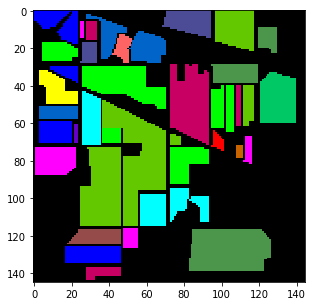

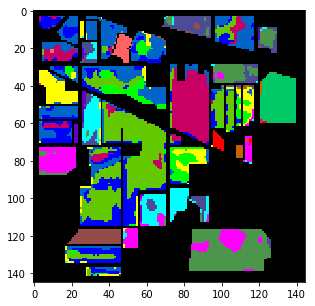

In [11]:
ground_truth = spectral.imshow(classes = output_image,figsize =(5,5))
predict_image = spectral.imshow(classes = predicted_image.astype(int),figsize =(5,5))

In [ ]:
# f_out = open('Predictions.pkl','ab')
# pkl.dump({'11x11_aug':predicted_results}, f_out)
# f_out.close()